In [ ]:
# Correlation between direction of movement and Temperature
# Pia Goecke, pia.goecke@uni-oldenburg.de
# 25.10.2024

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import pandas as pd
import matplotlib.animation as animation
import numpy as np
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os
import matplotlib.dates as mdates
import matplotlib as mpl
import re
from itertools import chain
import matplotlib
import matplotlib.ticker as ticker
import scipy.io
from statsmodels.nonparametric.smoothers_lowess import lowess
import gsw
from scipy.stats import pearsonr
from matplotlib.pyplot import cm
from cartopy import config
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotx
from cycler import cycler
from matplotlib.dates import date2num
import cartopy.feature as cfeature  #adding features in the map
#import gpxpy
import xml.etree.ElementTree as ET
import plotly.graph_objs as go
#from pandas import factorize

In [2]:
os.chdir('C:/Users/piago/Documents/Uni/5_Semester/Hiwi')
csv_file = "C:/Users/piago/Documents/Uni/5_Semester/Hiwi/Data/HE614_All_Grids_Single_Sheet.xlsx"

# Read the Excel file
df = pd.read_excel(csv_file, skiprows=10)
df = df.set_index('Date_Time')
df.index = pd.to_datetime(df.index)

In [3]:
df = df.loc['2023-03-09']
df.rename(columns={'CTD_Temperature_SML' : 'CTD_Temp_SML',
                   'CTD_Temperature_30cm' : 'CTD_Temperature_30cm_[°C]',
                   'CTD_Temperature_40cm' : 'CTD_Temperature_40cm_[°C]',
                   'CTD_Temperature_85cm' : 'CTD_Temperature_85cm_[°C]',
                   'CTD_Temperature_100cm' : 'CTD_Temperature_100cm_[°C]'}, inplace= True)

df=df.dropna(how='all', subset=df.columns)

In [4]:
# same for all depths
df['time_numeric'] = (df.index - df.index.min()).total_seconds()  

coefficients = np.polyfit(df['time_numeric'], df['CTD_Temp_SML'], 2) # fit polynomial
polynomial = np.poly1d(coefficients) #create function
df['fitted_2_Temp_SML'] = polynomial(df['time_numeric']) #values
df['detrend_2_Temp_SML'] = df['CTD_Temp_SML'] - df['fitted_2_Temp_SML']
df['detrend_2_Temp_SML'] = df['detrend_2_Temp_SML'] + df['fitted_2_Temp_SML'].mean()

depths = [30, 40, 60, 85, 100]

for d in depths:
    coefficients = np.polyfit(df['time_numeric'], df[f'CTD_Temperature_{d}cm_[°C]'], 2) # fit polynomial
    polynomial = np.poly1d(coefficients) #create function
    df[f'fitted_2_Temp_{d}'] = polynomial(df['time_numeric']) #values
    df[f'detrend_2_Temp_{d}'] = df[f'CTD_Temperature_{d}cm_[°C]'] - df[f'fitted_2_Temp_{d}']
    df[f'detrend_2_Temp_{d}'] = df[f'detrend_2_Temp_{d}'] + (df[f'CTD_Temperature_{d}cm_[°C]'][0] - df[f'detrend_2_Temp_{d}'][0])


# devide runs
df_first = df[df['time_numeric']<(df['time_numeric'].max())*0.5] # first run 
df_second = df[df['time_numeric']>=(df['time_numeric'].max())*0.5] # second run

runs = [df_first, df_second]

In [5]:
#assign direction of movement

diagonal_limit = 0.0001

df['Direction'] =np.nan
for i in range(len(df)-3):
    if abs(df['Longitude'][i] - df['Longitude'][i+3]) < 0.00001:    #Northward (or south)
         #if abs(df['Longitude'][i] - df['Longitude'][i + 1]) < 0.000000001 and abs(df['Longitude'][i] - df['Longitude'][i - 1]) < 0.000000001:  # Check for diagonal
            df['Direction'][i] = 'Northwards'
            if df['Latitude'][i] > df['Latitude'][i+3]:
                df['Direction'][i] = 'Southwards'
         #else: df['Direction'][i] = np.nan
    elif df['Longitude'][i] < df['Longitude'][i + 1]:  # Eastward movement
            if abs(df['Latitude'][i] - df['Latitude'][i + 3]) < diagonal_limit and abs(df['Latitude'][i] - df['Latitude'][i - 3]) < diagonal_limit:  # Check for diagonal
                df['Direction'][i] = 'Eastwards'
            else:
                df['Direction'][i] = np.nan   
    elif df['Longitude'][i] > df['Longitude'][i + 1]:  # Westward movement
            if abs(df['Latitude'][i] - df['Latitude'][i + 3]) < diagonal_limit and abs(df['Latitude'][i] - df['Latitude'][i - 3]) < diagonal_limit:  # Check for diagonal
                df['Direction'][i] = 'Westwards'
            else:
                df['Direction'][i] = np.nan 



In [6]:
# factorize directions for correlation matrix
labels, categories = pd.factorize(df["Direction"])
df["Direction_labels"] = labels
df['Direction_labels'][df['Direction'].isna()]= np.nan

df['Direction_labels_SE'] = labels
df['Direction_labels_SE'][df['Direction'].isna()]= np.nan
df['Direction_labels_SE'][df['Direction'].isin(['Southwards', 'Northwards'])]= np.nan

In [7]:
df['Direction_labels_alt'] = labels
df['Direction_labels_alt'][df['Direction'] == 'Westwards']=1
df['Direction_labels_alt'][df['Direction'] == 'Eastwards']=2
df['Direction_labels_alt'][df['Direction'] == 'Northwards']=np.nan
df['Direction_labels_alt'][df['Direction'] == 'Southwards']=np.nan

In [8]:
df_first = df[df['time_numeric']<(df['time_numeric'].max())*0.5] # first run 
df_second = df[df['time_numeric']>=(df['time_numeric'].max())*0.5] # second run

runs = [df_first, df_second]

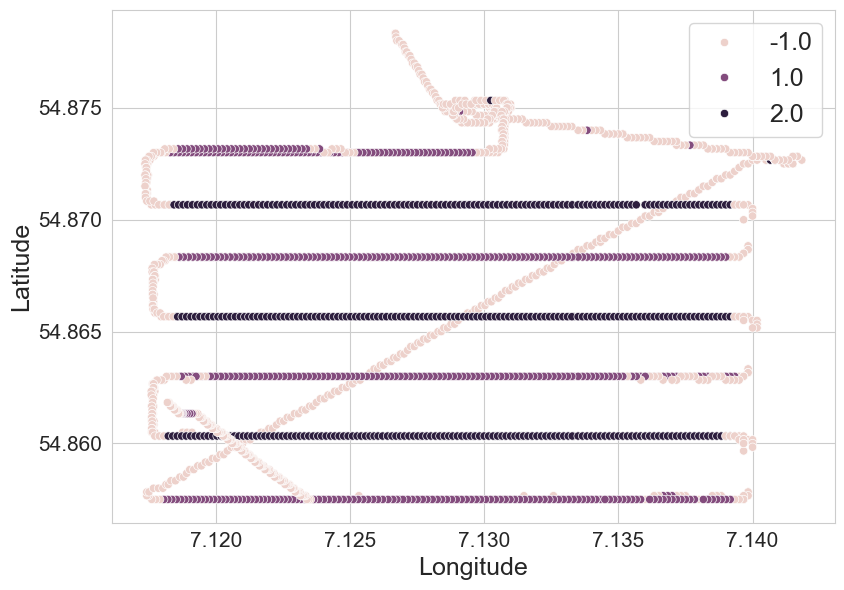

In [11]:
# plot direction
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
sns.scatterplot(data=df, x="Longitude", y="Latitude", hue="Direction_labels_alt")

plt.xlabel('Longitude', fontsize = 18)
plt.ylabel('Latitude', fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 18, bbox_to_anchor=(1.0, 1))
plt.tight_layout()

#plt.savefig('C:/Users/piago/Documents/Uni/5_Semester/Hiwi/Plots/20230309_Grid_directions.png')

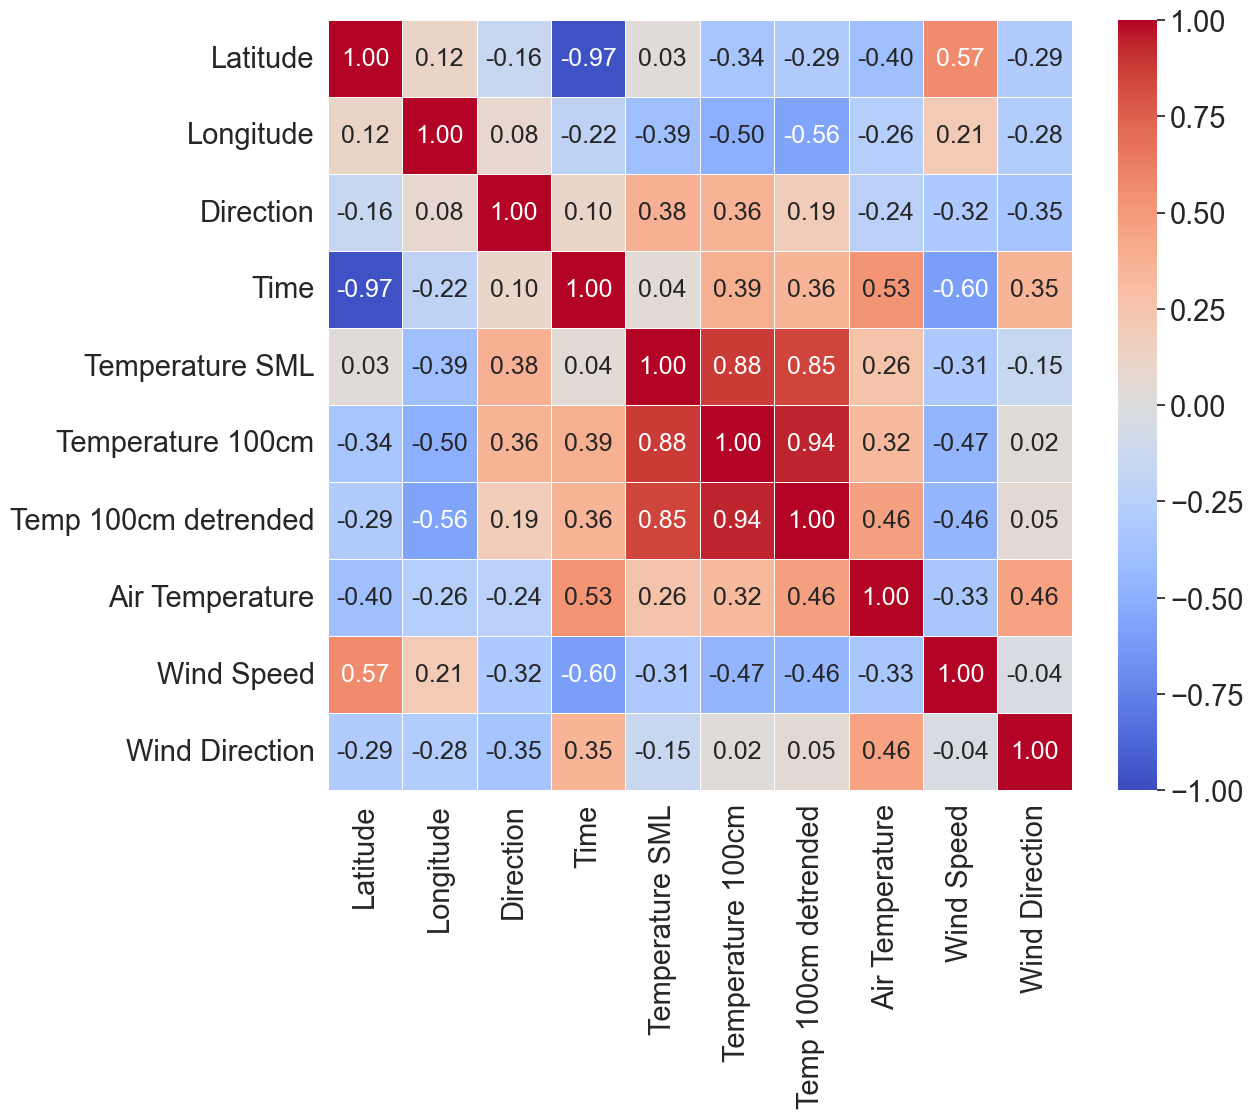

In [12]:
correlation_matrix = df_second[['Latitude', 'Longitude', 'Direction_labels_alt', 'time_numeric', 'CTD_Temp_SML', 'CTD_Temperature_100cm_[°C]', 'detrend_2_Temp_100', 'Campbell_Air_Temperature','Wind_Speed_U10','Campbell_Wind_Direction_True']].corr()


plt.figure(figsize=(12, 10))  # Set the size of the figure
sns.set(font_scale=1.9)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, annot_kws={"size": 18},
            yticklabels=['Latitude', 'Longitude', 'Direction', 'Time', 'Temperature SML', 'Temperature 100cm', 'Temp 100cm detrended', 'Air Temperature','Wind Speed','Wind Direction'],
            xticklabels=['Latitude', 'Longitude', 'Direction', 'Time', 'Temperature SML', 'Temperature 100cm', 'Temp 100cm detrended', 'Air Temperature','Wind Speed','Wind Direction'])
    
#
# plt.title('Correlation Matrix of Selected Columns', fontsize = 20)

plt.show()
# plt.savefig('C:/Users/piago/Documents/Uni/5_Semester/Hiwi/Plots/Correlation_2_run.png')

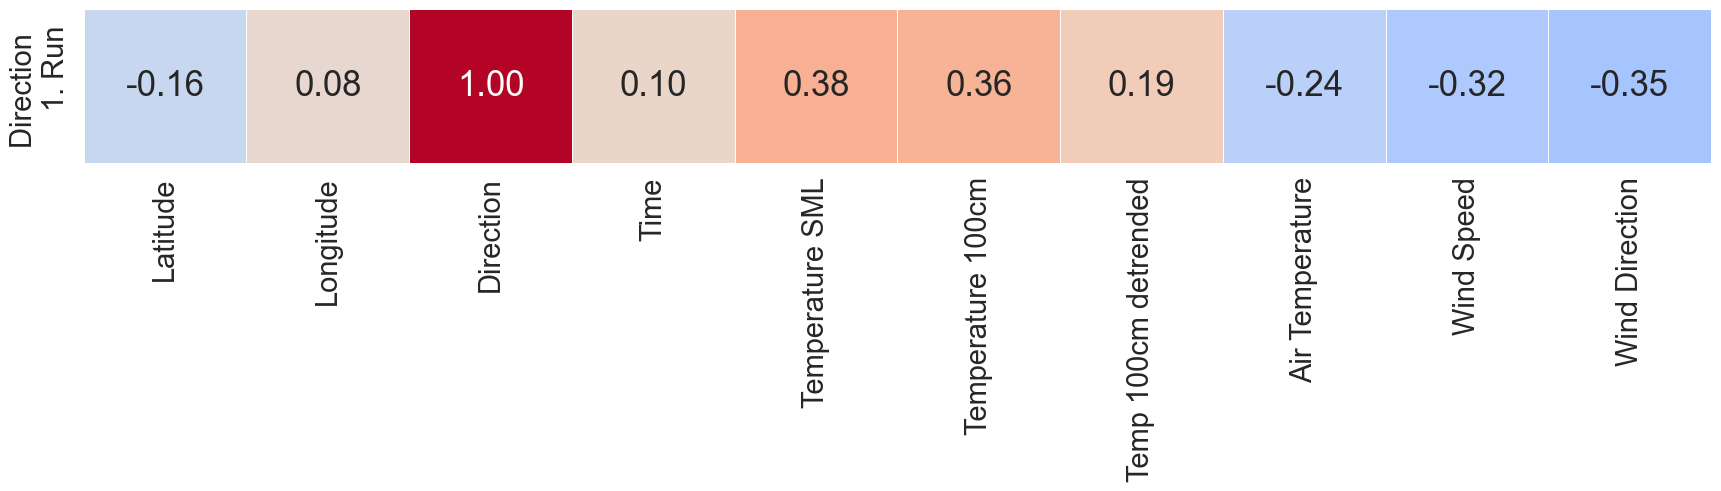

In [13]:
# show only row with Direction, first run
correlation_matrix = df_second[['Latitude', 'Longitude', 'Direction_labels_alt', 'time_numeric', 'CTD_Temp_SML', 'CTD_Temperature_100cm_[°C]', 'detrend_2_Temp_100', 'Campbell_Air_Temperature','Wind_Speed_U10','Campbell_Wind_Direction_True']].corr()
correlation_matrix_row = correlation_matrix.iloc[2]
correlation_matrix_row = correlation_matrix_row.values.reshape(1,-1)


plt.figure(figsize=(21,2))  # Set the size of the figure
sns.set(font_scale=1.9)
sns.heatmap(correlation_matrix_row, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, annot_kws={"size": 25},
            cbar=False, yticklabels=['Direction \n 1. Run'],
            xticklabels=['Latitude', 'Longitude', 'Direction', 'Time', 'Temperature SML', 'Temperature 100cm', 'Temp 100cm detrended', 'Air Temperature','Wind Speed','Wind Direction'])


plt.show()
#plt.savefig('C:/Users/piago/Documents/Uni/5_Semester/Hiwi/Plots/20230309_Correlation_2_run.png')

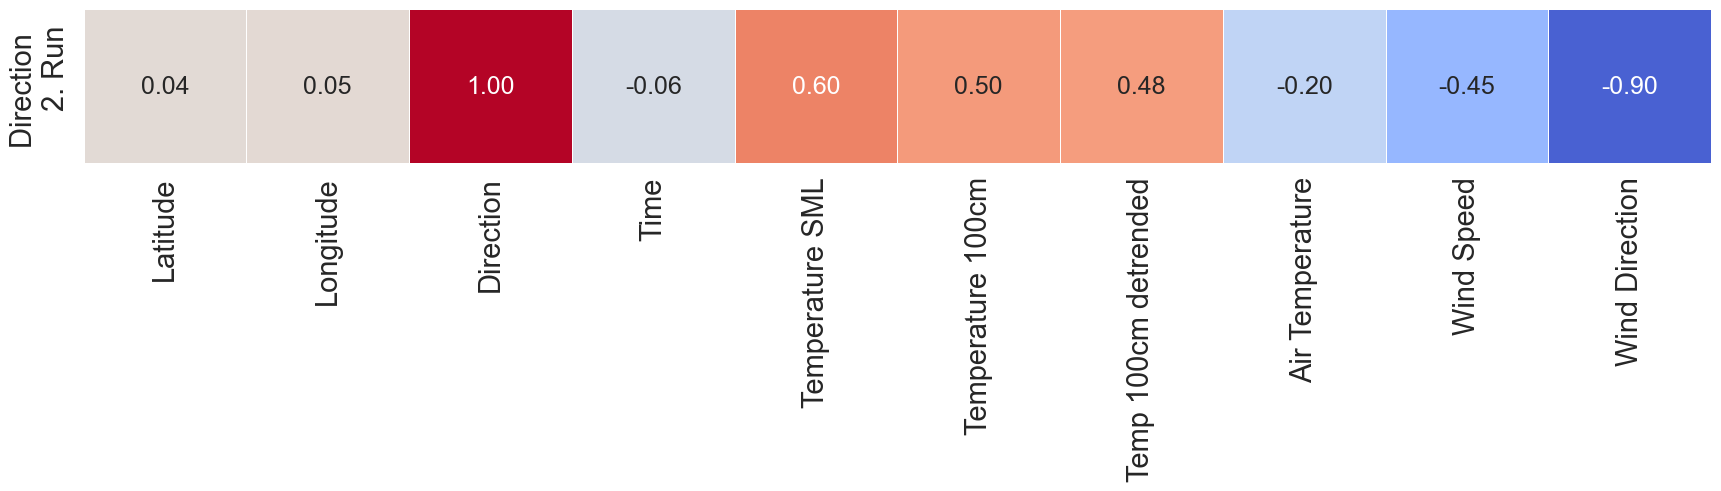

In [14]:
# same for 2. run

correlation_matrix = df_second[['Latitude', 'Longitude', 'Direction_labels_SE', 'time_numeric', 'CTD_Temp_SML', 'CTD_Temperature_100cm_[°C]', 'detrend_2_Temp_100', 'Campbell_Air_Temperature','Wind_Speed_U10','Campbell_Wind_Direction_True']].corr()
correlation_matrix_row = correlation_matrix.iloc[2]
correlation_matrix_row = correlation_matrix_row.values.reshape(1,-1)


plt.figure(figsize=(21,2))  # Set the size of the figure
sns.set(font_scale=1.9)
sns.heatmap(correlation_matrix_row, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, annot_kws={"size": 18},
            cbar=False, yticklabels=['Direction \n 2. Run'],
            xticklabels=['Latitude', 'Longitude', 'Direction', 'Time', 'Temperature SML', 'Temperature 100cm', 'Temp 100cm detrended', 'Air Temperature','Wind Speed','Wind Direction'])


plt.show()

In [15]:
# new column with Direction category, only west and east
df['Direction_WE']=df['Direction']
df['Direction_WE'][df['Direction'].isin(['Northwards', 'Southwards'])] = np.nan
df_cleaned = df.dropna(subset=['Direction_WE'])

df_first['Direction_WE']=df_first['Direction']
df_first['Direction_WE'][df_first['Direction'].isin(['Northwards', 'Southwards'])] = np.nan
df_first_cleaned = df_first.dropna(subset=['Direction_WE'])

df_second['Direction_WE']=df_second['Direction']
df_second['Direction_WE'][df_second['Direction'].isin(['Northwards', 'Southwards'])] = np.nan
df_second_cleaned = df_second.dropna(subset=['Direction_WE'])


In [16]:
#ANOVA for whole ds, 1. and 2. run

from scipy import stats

Anova_temp = 'detrend_2_Temp_30'

f_statistic_0, p_value_0 = stats.f_oneway(
    df[df['Direction'] == 'Westwards'][Anova_temp],
    df[df['Direction'] == 'Eastwards'][Anova_temp],
    df[df['Direction'] == 'Southwards'][Anova_temp],
    df[df['Direction'] == 'Northwards'][Anova_temp]
)

f_statistic_1, p_value_1 = stats.f_oneway(
    df_first[df_first['Direction'] == 'Westwards'][Anova_temp],
    df_first[df_first['Direction'] == 'Eastwards'][Anova_temp],
    df_first[df_first['Direction'] == 'Southwards'][Anova_temp],
    df_first[df_first['Direction'] == 'Northwards'][Anova_temp]
)

f_statistic_2, p_value_2 = stats.f_oneway(
    df_second[df_second['Direction'] == 'Westwards'][Anova_temp],
    df_second[df_second['Direction'] == 'Eastwards'][Anova_temp],
    df_second[df_second['Direction'] == 'Southwards'][Anova_temp],
    df_second[df_second['Direction'] == 'Northwards'][Anova_temp]
)

In [17]:
print(' whole Dataset, north, south, west and east')
print('f-statistic: ', f_statistic_0) # variance between the groups / variance within th groups. High -> groups are different
print('p-value: ', p_value_0)

print('\n first run, north, south, west and east')
print('f-statistic: ', f_statistic_1) # variance between the groups / variance within th groups. High -> groups are different
print('p-value: ', p_value_1)

print('\n second run, north, south, west and east')
print('f-statistic: ', f_statistic_2) # variance between the groups / variance within th groups. High -> groups are different
print('p-value: ', p_value_2)

 whole Dataset, north, south, west and east
f-statistic:  47.66468068449593
p-value:  1.549042996141885e-29

 first run, north, south, west and east
f-statistic:  67.60083719123541
p-value:  4.612523235042544e-39

 second run, north, south, west and east
f-statistic:  108.20421321740353
p-value:  4.77658905375393e-59


In [18]:
# mean T grouped by directions
df_first.groupby('Direction')['detrend_2_Temp_SML'].mean()

Direction
Eastwards     5.859460
Northwards    5.804195
Southwards    5.815652
Westwards     5.910668
Name: detrend_2_Temp_SML, dtype: float64

In [19]:
df_second.groupby('Direction')['detrend_2_Temp_SML'].mean()

Direction
Eastwards     5.906310
Northwards    5.768432
Southwards    5.826028
Westwards     5.830790
Name: detrend_2_Temp_SML, dtype: float64